In [ ]:
# Imports
import os
import sqlite3
from chemkin_CS207_G9.parser.database_query import CoeffQuery
from chemkin_CS207_G9.parser.xml2dict import xml2dict
from chemkin_CS207_G9.reaction.Reaction import Reaction
from chemkin_CS207_G9.reaction.ReactionSystem import ReactionSystem
import chemkin_CS207_G9.data as data_folder
import graphviz 
from graphviz import Digraph
import numpy as np
import random
import imageio
# imageio.plugins.ffmpeg.download()

from moviepy.editor import *
# Paths
BASE_DIR = os.path.dirname(os.path.abspath(data_folder.__file__))
path_xml = os.path.join(BASE_DIR, 'rxns_reversible.xml') # path to the .xml file
path_sql = os.path.join(BASE_DIR, '/test/nasa_thermo.sqlite')  # path to the .sqlite file

## Basic tests to learn how graphviz works

In [ ]:
# Preparing to query NASA Coefficients
nasa_query = CoeffQuery(path_sql)
db = sqlite3.connect(path_sql)
cursor = db.cursor()

# Selecting all coefficients from LOW database
query = '''SELECT * FROM LOW'''
cursor.execute(query).fetchall();

In [ ]:
# Loading Reactions and Species from xml file
reader = xml2dict()
reader.parse(path_xml)
info = reader.get_info()
# Getting species
species = info[0]
# Getting reactions
reactions = [Reaction(**r) for r in info[1]]

In [ ]:
# Defining Style

styles = {
    'graph': {
        'fontsize': '16',
        'fontcolor': 'white',
        'bgcolor': '#333333',
        'rankdir': 'BT',
        'pad':'1'
    },
    'nodes': {
        'fontname': 'Helvetica',
        'shape': 'octagon',
        'fontcolor': 'white',
        'color': 'white',
        'style': 'filled',
        'fillcolor': 'black',
    },
    'edges': {
        'style': 'dashed',
        'color': 'white',
        'arrowhead': 'open',
        'fontname': 'Courier',
        'fontsize': '12',
        'fontcolor': 'white',
    }
}


In [ ]:
top = Digraph('Top graph',comment='Hierarchical Graph')
high = Digraph('Reactant graph')
low = Digraph('Product graph')
midhigh = Digraph('Reactant graph')
midlow = Digraph('Product graph')

high.graph_attr.update(rank='source')
midhigh.graph_attr.update(rank='source')
midlow.graph_attr.update(rank='min')
low.graph_attr.update(rank='max')

reactant_count = {s:0 for s in species}
product_count = {s:0 for s in species}

def is_reactant(s):
    for r in reactions:
        if s in r.getReactants().keys():
            return True

def is_product(s):
    for r in reactions:
        if s in r.getProducts().keys():
            return True

for s in species:
    for r in reactions:
        if s in r.getReactants().keys():
            reactant_count[s]+=1
        if s in r.getProducts().keys():
            product_count[s]+=1
top.graph_attr.update(styles['graph'])
top.node_attr.update(styles['nodes'])
top.edge_attr.update(styles['edges'])
top.graph_attr.update(rankdir='LR')
top.graph_attr.update(ranksep='2')
# top.graph_attr.update( rank = 'min')   #rankdir='LR',
# bot.graph_attr.update( rank = 'min')
# top.graph_attr.update(('graph' in styles and styles['graph']) or {})


# top.node_attr.update(newrank = 'True')
# top.node_attr.update(rank = 'same')
# print('reactant_count,product_count',reactant_count,product_count)
for s in species:
#     print(s)
#     print('reactant_count[s],product_count[s]',reactant_count[s],product_count[s])
    if reactant_count[s] == 0:
        print(s,'is pure reactant')
        high.node(s)
    elif product_count[s] == 0:
        print(s,'is pure product')
        low.node(s)
    elif reactant_count[s] >= product_count[s]:
        print(s,'is more reactant than product')
        midhigh.node(s)
    elif reactant_count[s] < product_count[s]:
        print(s,'is more product than reactant')
        midlow.node(s)

random.seed(2017)
graphics = {}
for r in reactions[:9]:
    color = '#%02X%02X%02X' % (random.randint(0,255),random.randint(0,255),random.randint(0,255))
#     print(color)
    graphics['color'] = color
    for idx, k1 in enumerate(r.getReactants().keys()):
        for i,k in enumerate( r.getProducts() ):
            top.edge(k1, k,  color = color)
        for jdx, k2 in enumerate(r.getReactants().keys()):
            if k1 != k2 and jdx > idx:
                top.edge(k1, k2, arrowhead = 'none', color = color, style = 'filled')   
                
#top.graph_attr.update(('edges' in styles and styles['edges']) or {})
top.subgraph(high)
top.subgraph(midhigh)
top.subgraph(midlow)
top.subgraph(low)
# high.node_attr.update(rank = 'same')  
# midhigh.node_attr.update(rank = 'same')  
# midlow.node_attr.update(rank = 'same')   
# low.node_attr.update(rank = 'same')    
# top.node_attr.update(rank = 'same')
print('top.graph_attr',top.graph_attr)
print('top.node_attr',top.node_attr)
print(top.graph_attr)
print(low)
top.view()

## HierarchicalRSGraph Final Class

In [9]:
import imageio
imageio.plugins.ffmpeg.download()
from moviepy.editor import ImageClip, concatenate_videoclips
import random
import graphviz 
from graphviz import Digraph
from chemkin_CS207_G9.parser.database_query import CoeffQuery
from chemkin_CS207_G9.parser.xml2dict import xml2dict
from chemkin_CS207_G9.reaction.Reaction import Reaction
from chemkin_CS207_G9.reaction.ReactionSystem import ReactionSystem
import numpy as np
import random


class RSGraph():
    """
    THIS IS A BASE CLASS
    
    RSGraph is basically the parent class of two types of network graph: BipartiteRSGraph and HierarchicalRSGraph, which are to generate a graph to visualize one or multiple reactions.
    The base class RSGraph builds some basic settings of the graph plot.
    
    ATTRIBUTES
    ===========
    rs: ReactionSystem object, pass in the reaction system to be built graph
    top: graphviz Digraph, dot graph to be plotted graph
    default_style: a dictionary with 3 sub-dictionaries of "graph", "node", "edge", default setting of graph
    
    INITIALIZATION
    ===============
    __init__(self, reaction_sys, format="pdf",style=None)
    
    
    INPUTS: 
    ---------------
        reaction_sys: ReactionSystem object, reaction system to build network graph
        format: Optional string, graph format to be expected to show, initilizaed to be "pdf"
        style: Optional, a dictionary with 3 sub-dictionaries of "graph", "node", "edge", initialized to default_style as follows.
    
    METHODS
    =======
    modify_current_style(self, style):
        modify the current style of graph
        Inputs: 
            style: a dictionary with 3 sub-dictionaries of "graph", "node", "edge", initialized to default_style as follows.
    
    reset_default_style(self):
        reset the style (self.current_style) to be default (self.default_style)
    
    plot(self,method='jupyter',path=""):
        Displays current top graph in jupyter or pdf version. If pdf selected, also saves the image. 
        If no path has been specified, the image is saved in the current directory.
        Inputs:
            method: optional string, "jupyter" or "pdf", default to be "jupyter"
            path: optional string, saved path, default to be the current directory.
        
    
    EXAMPLE
    ========
    rs = ReactionSystem(reactions)
    graph = RSGraph(rs)
    graph.plot()   # Displays a graph with customized setting on a jupyter notebook without saving to pdf
    
    """
    
    def __init__(self, reaction_sys, format="pdf",style=None):
        self.rs = reaction_sys
        
        self.default_style = {
        'graph': {
            'fontsize': '16',
            'fontcolor': 'white',
            'bgcolor': '#333333',
            'rankdir': 'LR',
            'pad':'1'
        },
        'nodes': {
            'fontname': 'Helvetica',
            'shape': 'circle',
            'fontcolor': 'white',
            'color': 'white',
            'style': 'filled',
            'fillcolor': 'black',
        },
        'edges': {
            'style': 'dashed',
            'color': 'white',
            'arrowhead': 'open',
            'fontname': 'Courier',
            'fontsize': '12',
            'fontcolor': 'white',
        }
        }
        
        self.color_list = ['#4285f4', '#ea4335','#fbbc05','#34a853','#ffffff',
                           '#ff9300','#fb5f02','#b83709','#fbf23d','#ffaf04']
        
        
        self.current_style = self.default_style
        self.initialize_top_graph(format)
    
    
    def initialize_top_graph(self, format="pdf"):
        self.top = Digraph(format = format)
        self.apply_style(self.current_style)
    

    def apply_style(self, style):
        """
        Changes the style of the top graph. Input style should be a dictionary with 3 sub-dictionaries:
        one for graph, one for nodes and one for edges.
        """
        self.top.graph_attr.update(('graph' in style and style['graph']) or {})
        self.top.node_attr.update(('nodes' in style and style['nodes']) or {})
        self.top.edge_attr.update(('edges' in style and style['edges']) or {})
       
    
    def get_random_color(self):
        """
        Generates a random hexadecimal color.
        """
        return '#%02X%02X%02X' % (random.randint(0,255),random.randint(0,255),random.randint(0,255))
         
    def reset_default_style(self):
        self.modify_current_style(self.default_style)
      
    def modify_current_style(self, style):
        self.current_style = style
    
    def plot(self,method = 'jupyter',path="RSGraph"):
        """
        Displays current top graph in jupyter or pdf/png/jpeg version. If jupyter is not selected, also saves the image. 
        If no path has been specified, the image is saved in the current directory.
        """
        if method == 'jupyter':
            return self.top
        else:
            self.top.view(filename=path)
    
#    def plot_reactions(self, method = 'jupyter', path = "", idxs = []):
#        raise NotImplementedError
#        
#    def plot_system(self,method='pdf',path=""):
#        raise NotImplementedError
#        
#    def save_evolution_mp4(self,system,reactions,timesteps=5, path = ""):
#        raise NotImplementedError
#        
#    def set_edges(self, reaction, color):
#        raise NotImplementedError
#        
#    def save_mp4(self,imgs, path):
#        raise NotImplementedError

        
class BipartiteRSGraph(RSGraph):
    """
    This class generates a graph to visualize the whole reaction system. 
    It builds nodes for both species and id of equation and seperate them into two parts.
    We construct a bipartite graph with species as nodes (u,1) in one side, and reactions as nodes (u,2) in another side. 
    Build directed edges (u,1) to (v,2) if edge u is the reactant of equation v. 
    Build directed edges (u,2) to (v,1) if edge v is the product of equation u. 
    Set edges to be dashed if the equation is reversible, otherwise filled.
    From this graph, we could recompute the reaction equations.
    The graph assigns a color to each equation (can be defined by the user) and can show concentration of a given specie in the set of reactions by size of the node.
    The reactions can be plotted with different grouping options and style options.
    
    METHODS
    =======
    plot_system(self, method='jupyter', path=""):
        plot the bipartite graph for the whole reaction system with optional parameters method and path passed to plot function.
        Inputs:
            method: optional string, "jupyter" or "pdf", default to be "jupyter"
            path: optional string, saved path, default to be the current directory.

    EXAMPLES
    ========
    rs = ReactionSystem(reactions)
    b_graph = BipartiteRSGraph(rs)
    b_graph.plot_system(method='jupyter') 

    
    """
    
    def plot_system(self, method='jupyter', path=""):
        self.initialize_top_graph()
        
        self.top.graph_attr.update(rankdir='LR')
        
        self.top.graph_attr.update(ranksep='2')
        
        with self.top.subgraph(name='cluster_1') as c:
#             c.attr(label='Reaction', labelloc = 'b')
            c.attr(label='Reaction')
            c.attr(color='white')
            for idx in range(len(self.rs.get_reactions())):
                c.node(str(idx))

        with self.top.subgraph(name='cluster_0') as c:
            c.attr(color='white')
            c.attr(label='Species')
            for s in self.rs.get_species():
                c.node(s)
        
        for idx, r in enumerate(self.rs.get_reactions()):
            c = self.get_random_color()
            if r.is_reversible():
                for k1 in r.getReactants():
                    self.top.edge(k1, str(idx), color = c)
                for k2 in r.getProducts():
                    self.top.edge(str(idx), k2, color = c)
            else:
                for k1 in r.getReactants():
                    self.top.edge(k1, str(idx), color = c, style = "filled")
                for k2 in r.getProducts():
                    self.top.edge(str(idx), k2, color = c, style = "filled")
        
        return self.plot(method=method, path=path)    
    




class HierarchicalRSGraph(RSGraph):
    """
    This class generates a graph to visualize one or multiple reactions. The graph assigns a color to each equation 
    (can be defined by the user) and can show concentration of a given specie in the set of reactions by size of the node.
    The reactions can be plotted all at once or separately, with different grouping options and style options.
    
    ATTRIBUTES
    ==========
    reac_system: ReactionSystem object to represent.
    target_file: Optional. File path indicating where to save the generated graph.
    
    METHODS
    =======
    build_reaction_graph(self, reaction, prefix = "cluster", color = None):
        Creates a graph for one reaction. If the prefix cluster is sent, the reaction 
        gets plotted in its own cluster, and is a subgraph of the main plot. Color
        sets the color of the edges.
    
    plot_reactions(self, method = 'jupyter', path = "RSGraph", idxs = []):
        Plots all the reactions on the current ReactionSystem on different clusters.
        the varibale idxs can be used to plot certain reactions and not others.
        For example, idxs=[2,3] only plots the reactions with index 2 and 3 in the 
        reaction list of the ReactionSystem.
   
    plot_system(self,method='jupyter',path="RSGraph",colors=None):
        Plots the Reaction system as a whole, without separation between reactions. Shows how each specie interacts 
        In the full reaction system. If the amount of reactions in the system is less than 4, the plot will be generated
        With 2 columns of species, representing on the left the species that are more reactant than product, and on the right
        the species that are more product than reactant. If the system has more than 4 reactions, an automatic organization
        of nodes is performed instead.
        
    set_edges(self, g, reaction, color, node_prefix = ""):
        Generates the edges for a reaction. Edges are dotted for Reactant to Product and filled for product to reactant.

    save_evolution_mp4(self, solver_step_size = 1e-14, timesteps=5, path="HGRSVideo")L:
        Generates and saves and mp4 with the evolution of the system on n timesteps, 
        with an ODE step size defined by the user. 
    
    EXAMPLES
    ========
    >>> rs = ReactionSystem([Reaction(), Reaction()])
    >>> h_graph = HierarchicalRSGraph(rs)
    >>> h_graph.view(method='jupyter')   # Displays on a jupyter notebook without saving to pdf
    
    """
    
           
    def build_reaction_graph(self, reaction, prefix = "cluster", color = None):
        """
        Creates a graph for one reaction. If the prefix cluster is sent, the reaction 
        gets plotted in its own cluster, and is a subgraph of the main plot. Color
        sets the color of the edges.
        """
        
        if color == None:
            color =self.get_random_color()
            
        r_graph = Digraph(prefix+'Reaction')
        r_graph.graph_attr.update(label = reaction.get_reaction_equation())
        
        for s in reaction.getReactants().keys():
            r_graph.node(reaction.get_reaction_equation()+' --- '+s, label = s, rank = 'min')
        for s in reaction.getProducts().keys():
            r_graph.node(reaction.get_reaction_equation()+' --- '+s, label = s, rank = 'max')
        
        
        r_graph = self.set_edges(r_graph, reaction, color, node_prefix=reaction.get_reaction_equation()+' --- ')
            
        return r_graph

            
            
    def plot_reactions(self, method = 'jupyter', path = "RSGraph", idxs = []):
        """
        Plots individual graphs for each reaction in the ReactionSystem. The variable idxs allows the user
        to select specific reactions from the RS system to plot.
        """
        
        if method != 'jupyter':
            self.initialize_top_graph(format=method)
        else:
            self.initialize_top_graph()
        
        if not idxs:
            idxs = list(range(len(self.rs.get_reactions())))
            
        r_graph = []
        for i,r in enumerate([self.rs.get_reactions()[i] for i in idxs]):
            r_graph.append( self.build_reaction_graph(r, prefix = 'cluster'+str(i)) )
            self.top.subgraph(r_graph[i])
        
        return self.plot(method = method, path=path) 

        
    def plot_system(self,method='jupyter',path="RSGraph",colors=None):
        """
        Plots the Reaction system as a whole, without separation between reactions. Shows how each specie interacts 
        In the full reaction system. If the amount of reactions in the system is less than 4, the plot will be generated
        With 2 columns of species, representing on the left the species that are more reactant than product, and on the right
        the species that are more product than reactant. If the system has more than 4 reactions, an automatic organization
        of nodes is performed instead.
        """
        if method != 'jupyter':
            self.initialize_top_graph(format=method)
        else:
            self.initialize_top_graph()
        self.top.graph_attr.update(rankdir='LR')
        concs = self.rs.get_concs()
        init_concs = self.rs.get_init_concs()
#         print('init_concs',init_concs)
        suffix={}
        concs_dev={}
        for s in self.rs.get_species():
            if concs and init_concs:
                suffix[s]='\n'+"{0:.2f}".format(concs[s])
                concs_dev[s] = 1 / (1 + np.exp(-4*(concs[s]-init_concs[s])))
            else:
                print('HEY')
                suffix[s]=''
                concs_dev[s] = 0.1
        
        
        if len(self.rs.get_reactions()) <=4:
            self.top.graph_attr.update(ranksep='2')
            reac = Digraph('Reactant graph')
            prod = Digraph('Product graph')
            reac.graph_attr.update(rank = 'source')
            prod.graph_attr.update(rank = 'sink')
            reactant_count = {}
            product_count = {}
            for s in self.rs.get_species():
                reactant_count[s]=0
                product_count[s]=0
                for r in self.rs.get_reactions():
                    if s in r.getReactants().keys():
                        reactant_count[s]+=1
                    if s in r.getProducts().keys():
                        product_count[s]+=1
            for s in self.rs.get_species(): 
                if reactant_count[s] >= product_count[s]:
                    reac.node(s, label = s+suffix[s], style='filled', 
                              fillcolor='#997777;'+'{0:.2f}'.format(concs_dev[s])+':#333333', gradientangle='90')
                elif reactant_count[s] < product_count[s]:
                    prod.node(s, label = s+suffix[s], style='filled', 
                              fillcolor='#997777;'+'{0:.2f}'.format(concs_dev[s])+':#333333', gradientangle='90')
            self.top.subgraph(reac)
            self.top.subgraph(prod)
        else:
            for s in self.rs.get_species():
                self.top.node(s, label = s+suffix[s], style='filled', 
                              fillcolor='#997777;'+'{0:.2f}'.format(concs_dev[s])+':#333333', gradientangle='90')
        
        
        for i,reaction in enumerate(self.rs.get_reactions()):
            if colors == None:
                color = self.get_random_color()
            else:
                color = colors[i%len(colors)]
            self.top = self.set_edges(self.top, reaction, color)
    
        return self.plot(method=method, path=path)
    
    def set_edges(self, g, reaction, color, node_prefix = ""):
        """
        Generates the edges for a reaction. Edges are dottes for Reactant to Product and filled for product to reactant.
        """
        for idx, s1 in enumerate(reaction.getReactants().keys()):
            for s2 in reaction.getProducts().keys():
                if reaction.is_reversible():
                    g.edge(node_prefix+s1, node_prefix+s2, dirtype='both', color = color, penwidth='2')
                else:
                    g.edge(node_prefix+s1, node_prefix+s2, color = color)
            for jdx, s2 in enumerate(reaction.getReactants().keys()):
                if s1 != s2 and jdx > idx:
                    g.edge(node_prefix+s1, node_prefix+s2, arrowhead = 'none', color = color, style = 'filled',  penwidth='1.5') 
        return g
                    
    
    def save_evolution_mp4(self, solver_step_size = 1e-14, timesteps=5, path="HGRSVideo"):
        """
        Generates and saves and mp4 with the evolution of the system on n timesteps, 
        with an ODE step size defined by the user. 
        """
        clip_paths = []        
        for n in range(timesteps):
            self.rs.evolute(solver_step_size)
            self.plot_system(method = 'png', path = path + "_img"+str(n), colors=self.color_list)
            clip_paths.append(path + "_img"+str(n)+'.png')
        frames = [ImageClip(img).set_duration(0.1) for img in clip_paths]
        movie = concatenate_videoclips(frames, method="compose")
        movie.write_videofile(path+".mp4", fps=30)

## Testing

In [10]:
# Testing
import os
import sqlite3
from chemkin_CS207_G9.parser.database_query import CoeffQuery
from chemkin_CS207_G9.parser.xml2dict import xml2dict
from chemkin_CS207_G9.reaction.Reaction import Reaction
from chemkin_CS207_G9.reaction.ReactionSystem import ReactionSystem
import chemkin_CS207_G9.data as data_folder
import graphviz 
from graphviz import Digraph
import numpy as np
import random
import imageio
from moviepy.editor import *
from chemkin_CS207_G9.plotting.RSGraph import HierarchicalRSGraph

# Paths
BASE_DIR = os.path.dirname(os.path.abspath(data_folder.__file__))
print(BASE_DIR)
path_xml = os.path.join(BASE_DIR, 'rxns_reversible.xml') # path to the .xml file
path_sql = os.path.join(BASE_DIR, 'nasa_thermo.sqlite')  # path to the .sqlite file
print(path_sql)

# Loading Reactions and Species from xml file
reader = xml2dict()
reader.parse(path_xml)
info = reader.get_info()
species = info[0]
reactions = [Reaction(**r) for r in info[1]]
cq = CoeffQuery(path_sql)
rs1 = ReactionSystem(reactions[:3], nasa_query = cq)
rs2 = ReactionSystem(reactions, species_ls = species, nasa_query = cq)
rs3 = ReactionSystem(reactions[:4], nasa_query = cq)
temperature = 2500
concentrations = dict(H=2, O=1, OH=0.5, H2=1, H2O=1, O2=1)
rs1.set_temp(temperature)
rs1.set_concs(concentrations, initial=True)

def test_plot_system_notebook():
    h_graph = HierarchicalRSGraph(rs1)
    g = h_graph.plot_system(method = 'jupyter', path = 'test_plot_system_notebook.pdf')
    assert(type(g) == Digraph)
    return g

def test_plot_system_notebook_with_no_concs():
    h_graph = HierarchicalRSGraph(rs3)
    g = h_graph.plot_system(method = 'jupyter', path = 'test_plot_system_notebook.pdf')
    assert(type(g) == Digraph)
    return g
      
def test_plot_reactions_notebook():
    h_graph = HierarchicalRSGraph(rs1)
    g=h_graph.plot_reactions(method = 'jupyter')
    assert(type(g) == Digraph)
    return g

def test_wrong_plot_method():
    h_graph = HierarchicalRSGraph(rs1)
    try:
        h_graph.plot_system(method = 'wrong_format')
    except Exception as err:
        assert(type(err) == ValueError)
        
def test_plot_system_more_than_4_reactions():
    h_graph = HierarchicalRSGraph(rs2)
    g= h_graph.plot_system(method = 'jupyter')
    assert(type(g) == Digraph)
    return g

def test_plot_only_2_reactions():
    h_graph = HierarchicalRSGraph(rs1)
    g=h_graph.plot_reactions(method = 'jupyter', idxs = [2,1])
    assert(type(g) == Digraph)
    return g

def test_plot_single_reaction():
    h_graph = HierarchicalRSGraph(rs1)
    g= h_graph.plot_reactions(method = 'jupyter', idxs = [1])
    assert(type(g)==Digraph)
    return g

def test_plot_reaction_idx_out_of_range():
    h_graph = HierarchicalRSGraph(rs1)
    try:
        h_graph.plot_reactions(method = 'jupyter', idxs = [7])
    except Exception as err:
        assert(type(err)==IndexError)
        
def test_changing_styles():
    h_graph = HierarchicalRSGraph(rs1)
    new_style = {
        'graph': {
            'fontsize': '16',
            'fontcolor': 'white',
            'bgcolor': '#333333',
            'rankdir': 'BT',
            'pad':'1'
        },
        'nodes': {
            'fontname': 'Helvetica',
            'shape': 'circle',
            'fontcolor': 'white',
            'color': 'white',
            'style': 'dashed',
            'fillcolor': 'black',
        },
        'edges': {
            'style': 'bold',
            'color': 'white',
            'arrowhead': 'empty',
            'fontname': 'Courier',
            'fontsize': '12',
            'fontcolor': 'white',
        }
    }
    
    h_graph.reset_default_style()
    h_graph.modify_current_style(new_style)
    g = h_graph.plot_system()
    assert(type(g)==Digraph)
    return g
    
def test_plot_system_pdf():
    h_graph = HierarchicalRSGraph(rs1)
    h_graph.plot_system(method = 'format', path = 'test_HRSG_system_pdf')
    
def test_plot_system_png():
    h_graph = HierarchicalRSGraph(rs1, format = 'png')
    h_graph.plot_system(method = 'format', path = 'test_HRSG_system_png')
    
def test_plot_reactions_pdf():
    h_graph = HierarchicalRSGraph(rs1)
    h_graph.plot_reactions(method = 'format', path = 'test_HRSG_reactions_pdf')

def test_evolution_mp4():
    h_graph = HierarchicalRSGraph(rs1)
    h_graph.save_evolution_mp4(solver_step_size = 7e-16, timesteps = 30)

C:\Users\Camilo\Dropbox\Graduate Studies\Harvard\CS207\cs207-FinalProject\chemkin_CS207_G9\data
C:\Users\Camilo\Dropbox\Graduate Studies\Harvard\CS207\cs207-FinalProject\chemkin_CS207_G9\data\nasa_thermo.sqlite


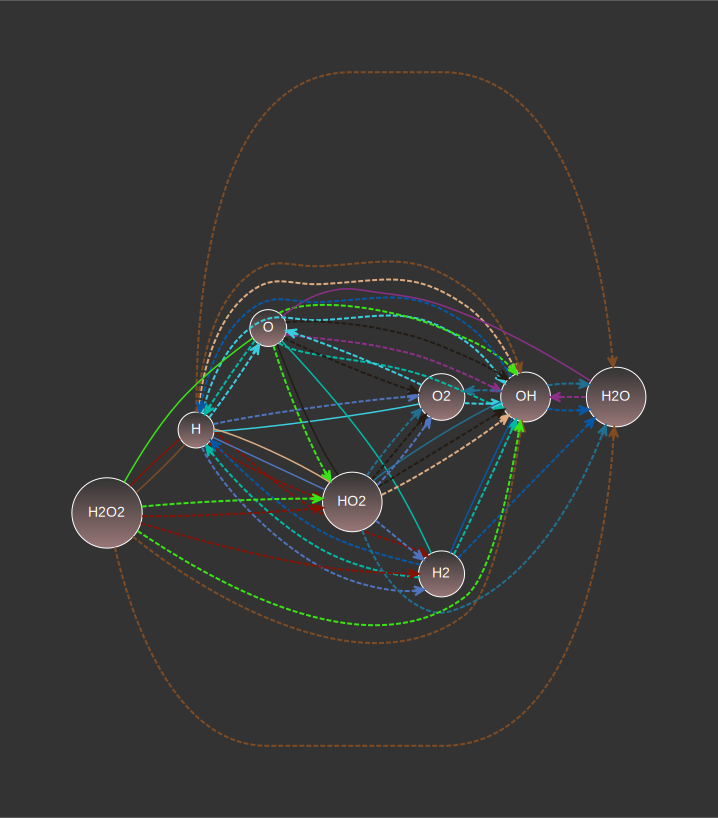

In [11]:
# test_plot_system_notebook()
# test_plot_reactions_notebook()
# test_wrong_plot_method()
# test_changing_styles()
test_plot_system_more_than_4_reactions()
# test_plot_only_2_reactions()
# test_plot_single_reaction()
# test_plot_reaction_idx_out_of_range()
#test_evolution_mp4()